# Image classification using CNNs and ResNets

## Exploring the data

In [1]:
import os
import torch
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, './data')

Using downloaded and verified file: ./data/cifar10.tgz


In [3]:
# Extract from archive
with tarfile.open('./data/cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir+"/train")
print(classes)

['test', 'train']
['truck', 'airplane', 'bird', 'ship', 'cat', 'automobile', 'frog', 'deer', 'horse', 'dog']


In [5]:
airplane_files = os.listdir(data_dir+'/train/airplane')
print('# of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

# of training examples for airplanes: 5000
['2357.png', '3617.png', '1118.png', '1867.png', '4109.png']


In [6]:
ship_test_files = os.listdir(data_dir+'/test/ship')
print('# of test examples for ship:', len(ship_test_files))
print(ship_test_files[:5])

# of test examples for ship: 1000
['0243.png', '0642.png', '0215.png', '0062.png', '0620.png']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [8]:
dataset = ImageFolder(data_dir+'/train',transform=ToTensor())

In [9]:
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: ToTensor()

In [10]:
img, label = dataset[0]
print(img.shape,label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [11]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
import matplotlib.pyplot as plt

def show_example(img,label):
    print('Label:',dataset.classes[label],'('+str(label)+')')
    plt.imshow(img.permute(1,2,0))

Label: airplane (0)


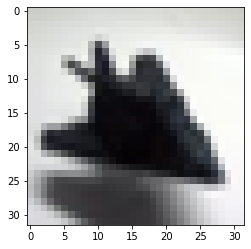

In [13]:
show_example(*dataset[0])

Label: airplane (0)


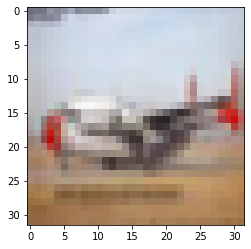

In [14]:
show_example(*dataset[1099])

## Training and validation Datasets

In [15]:
import numpy as np

def split_indices(n, val_pct=0.1, seed=99):
    #Determine size of validation set
    n_val = int(val_pct*n)
    #Set the random seed (for reproducibility)
    np.random.seed(seed)
    #Create random permutation of 0 to n-1
    idxs = np.random. permutation(n)
    #Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [16]:
val_pct = 0.2
rand_seed = 42
train_indices, val_indices = split_indices(len(dataset),val_pct,rand_seed)
print(len(train_indices),len(val_indices))
print('Sample validation indices: ', val_indices[:10])

40000 10000
Sample validation indices:  [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


In [17]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size = 100

In [18]:
#Training Sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

#Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images,10).permute(1,2,0))
        break

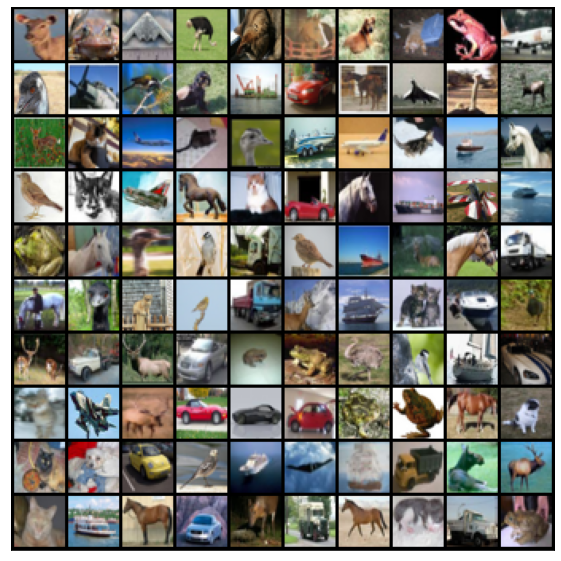

In [22]:
show_batch(train_dl)

## Defining the model (CNN) 

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(2,2)
)

In [25]:
for images, labels in train_dl:
    print("Images.shape:",images.shape)
    out = simple_model(images)
    print("out.shape:",out.shape)
    break

Images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 8, 16, 16])
